# Comparing USPR (https://github.com/cwhidden/uspr) and Leo's dSPR, in terms of accuracy and timing
- Both algorithms work on unrooted trees
- since the full USPR calculation has size constraints, I am focusing on its fast initial computations (approximate TBR, TBR and replug distance). We can assume, for all effects, that the full USPR calculation would always find the true unrooted SPR distance
- to make the timing comparisons fair, dSPR also loads (and initialise) only a pair of trees at a time, as does USPR. (Since dSPR can load all trees at once, speeding up further calculations.) Still there might be some overhead/imprecision due to the function `time.perf_counter()` used to do the timing comparison.

In [111]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import sys, subprocess, time, dendropy
import numpy as np

bindir="/home/leo/local/bin/"
localdir="/tmp/"

In [70]:
def run_uspr (tree1, tree2, fast = False):
    localfile = localdir + "pair.tre"
    dendropy.TreeList([tree1,tree2]).write(path=localfile, schema="newick")
    if fast:
        command_line = bindir + "uspr --tbr --replug < " + localfile
    else:
        command_line = bindir + "uspr < " + localfile
    start_time = time.perf_counter()
    proc_run = subprocess.run(command_line, shell=True, stdout=subprocess.PIPE, universal_newlines=True)
    elapsed_time = time.perf_counter() - start_time
    dists = [-1,-1,-1]
    for line in proc_run.stdout.splitlines():
        if "d_TBR =" in line:
            dists[0] = float(line.split(" ")[2].strip())
        if "d_R =" in line:
            dists[1] = float(line.split(" ")[2].strip())
        if "d_USPR =" in line:
            dists[2] = float(line.split(" ")[2].strip())
    return elapsed_time, dists # TBR, replug, SPR, respectively

In [147]:
def run_dspr (tree1, tree2):
    localfile = localdir + "pair.tre"
    dendropy.TreeList([tree1,tree2]).write(path=localfile, schema="nexus")
    start_time = time.perf_counter()
    proc_run = subprocess.run(bindir + "gf_spr_distance " + localfile, shell=True, stdout=subprocess.PIPE, 
                              universal_newlines=True)
    elapsed_time = time.perf_counter() - start_time
    line = proc_run.stdout.splitlines()[1].split()[1:4] # second line has dists as columns, we want 2nd~4th
    dists = [float(i) for i in line] # SPR, RF, Hdist, respectively
        
    return elapsed_time, dists

In [146]:
def generate_spr_trees (n_leaves, n_trees, n_spr):
    start_time = time.perf_counter()
    proc_run = subprocess.run([bindir + "gf_generate_spr_trees", str(n_leaves), str(n_trees), str(n_spr)],
                              stdout=subprocess.PIPE, universal_newlines=True)
    elapsed_time = time.perf_counter() - start_time
    return elapsed_time, dendropy.TreeList.get(data=proc_run.stdout, schema="nexus")

### Function that generates random trees and calculates SPR (and others) distances 

In [148]:
def simulate_estimate_spr (ntrees = 10, min_leaves=6, max_leaves=9, min_spr = 1, max_spr_f = 0.5, fast = True):
    o_tbl = []
    for nleaves in range(min_leaves, max_leaves+1):
        for nspr in range(1,int(max_spr_f * nleaves) + 1):
            _, trees = generate_spr_trees (nleaves,ntrees,nspr) ## remember that C function generates one extra tree!
            for i in range(1,ntrees):
                secs1, dists1 = run_uspr(trees[i-1],trees[i], fast)
                secs2, dists2 = run_dspr(trees[i-1],trees[i])
                header = [nleaves,nspr,secs1,secs2] # [0,3]
                o_tbl.append(header + dists1 + dists2) # 4-6 [tbr, replug, spr], 7-9 [spr,rf, hdist]
    return np.array(o_tbl)

In [149]:
X = simulate_estimate_spr (20, 10, 30, 1, 0.7, True)
np.save ("performance_table", X)

(5415, 10)


(0, 18)

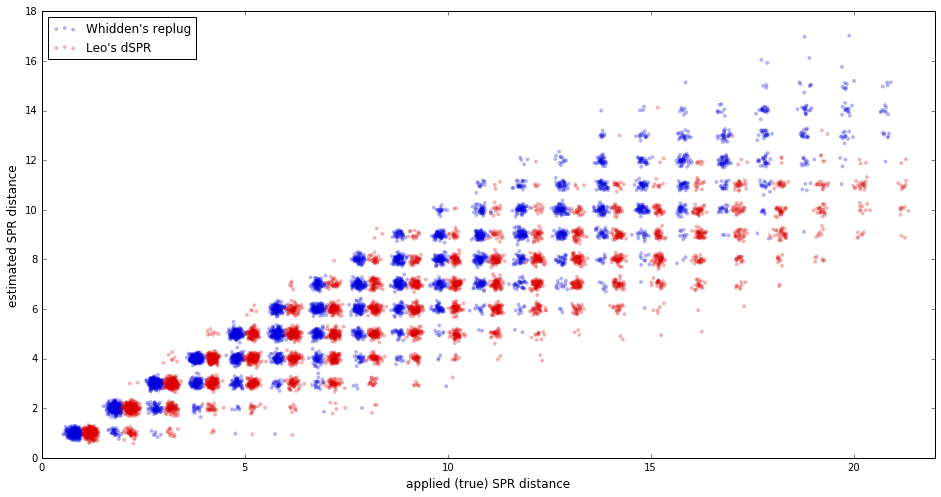

In [154]:
jit1 = np.random.normal(scale=0.1, size=X.shape[0])
jit2 = np.random.normal(scale=0.1, size=X.shape[0])
print (X.shape)
fig, axes = plt.subplots(1); fig.set_size_inches(16, 8)
axes.scatter(X[:,1]+0.8*jit1-0.2,X[:,5]+1.2*jit2, alpha=.3, s=15, edgecolor="none", c=plt.cm.spectral(0.2), label="Whidden's replug")
axes.scatter(X[:,1]+0.8*jit2+0.2,X[:,7]+1.2*jit1, alpha=.3, s=15, edgecolor="none", c=plt.cm.spectral(0.9), label="Leo's dSPR")
axes.legend(loc=2)
axes.set_xlabel("applied (true) SPR distance",fontsize=12)
axes.set_ylabel("estimated SPR distance",fontsize=12)
axes.set_xlim(0,22); axes.set_ylim(0,18)

### the figure above shows that the replug distance (from USPR) has a similar performance as dSPR, But at a very high computational price, as shown by the timings in the figure below.
- We cannot say with confidence (although I would say it is very reasonable) that the replug distance is better, since the number of **applied** SPRs to a tree does not equal the **minimum** number of SPRs separating the original and resulting trees.

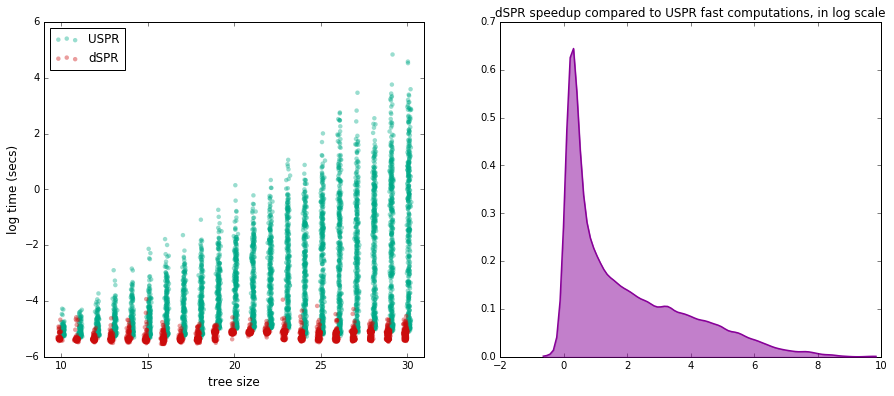

In [165]:
fig, axes = plt.subplots(1,2); fig.set_size_inches(15, 6)
axes[0].scatter(X[:,0]+0.5*jit1+0.1,np.log(X[:,2]), alpha=.4, s=20, edgecolor="none", c=plt.cm.spectral(0.4), label="USPR")
axes[0].scatter(X[:,0]+0.5*jit2-0.1,np.log(X[:,3]), alpha=.4, s=20, edgecolor="none", c=plt.cm.spectral(0.95), label="dSPR")
axes[0].legend(loc=2)
axes[0].set_ylim(-6,6); axes[0].set_xlim(9,31)
axes[0].set_xlabel("tree size",fontsize=12)
axes[0].set_ylabel("log time (secs)",fontsize=12)

from scipy.stats import gaussian_kde
speedup = np.log(X[:,2]) - np.log(X[:,3])
density = gaussian_kde(speedup)
density.covariance_factor = lambda : .09 # set the covariance_factor, lower means more detail
density._compute_covariance()
dx = np.linspace(np.percentile(speedup,q=0.01), np.percentile(speedup,q=99.99),100)
dy = density(dx)
axes[1].plot(dx, dy, linewidth=1.5, c=plt.cm.spectral(0.1))
axes[1].fill_between(dx, dy, alpha=.5, zorder=5, antialiased=True, color=plt.cm.spectral(0.1))
axes[1].set_title("dSPR speedup compared to USPR fast computations, in log scale")